In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

Setup the environment variables

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

In [0]:
!pip install pyspark

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.functions import col, avg
import seaborn as sns
spark = SparkSession.builder.appName("CS543_Project").master("local[*]").getOrCreate()

In [0]:
file_loc = "/content/drive/My Drive/Colab Notebooks/AB_NYC_2019.csv"
airbnb_schema = spark.read.csv(file_loc, inferSchema=True, header=True, multiLine=True, quote='"', escape='"')

In [0]:
airbnb_schema.show()
print("Total number of records in the dataset - ", airbnb_schema.count())

+----+--------------------+-------+----------------+-------------------+------------------+--------+---------+---------------+-----+--------------+-----------------+-------------------+-----------------+------------------------------+----------------+
|  id|                name|host_id|       host_name|neighbourhood_group|     neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|        last_review|reviews_per_month|calculated_host_listings_count|availability_365|
+----+--------------------+-------+----------------+-------------------+------------------+--------+---------+---------------+-----+--------------+-----------------+-------------------+-----------------+------------------------------+----------------+
|2539|Clean & quiet apt...|   2787|            John|           Brooklyn|        Kensington|40.64749|-73.97237|   Private room|  149|             1|                9|2018-10-19 00:00:00|             0.21|                             6|          

**8. Print the dataset schema to understand the type of data we are dealing with.**

In [0]:
airbnb_schema.printSchema()

root
 |-- id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- host_id: integer (nullable = true)
 |-- host_name: string (nullable = true)
 |-- neighbourhood_group: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- minimum_nights: integer (nullable = true)
 |-- number_of_reviews: integer (nullable = true)
 |-- last_review: timestamp (nullable = true)
 |-- reviews_per_month: double (nullable = true)
 |-- calculated_host_listings_count: integer (nullable = true)
 |-- availability_365: integer (nullable = true)



In [0]:
# Check for count of null values in each column of the dataframe.
print("Count of null values for each feature: ")
for col in airbnb_schema.columns:
  print(col, ": ", airbnb_schema.where(airbnb_schema[col].isNull()).count())

Count of null values for each feature: 
id :  0
name :  16
host_id :  0
host_name :  21
neighbourhood_group :  0
neighbourhood :  0
latitude :  0
longitude :  0
room_type :  0
price :  0
minimum_nights :  0
number_of_reviews :  0
last_review :  10052
reviews_per_month :  10052
calculated_host_listings_count :  0
availability_365 :  0


**We see that there are a lot of nulls by observing the first 20 rows of the dataset above. So, we checked the count of null values in each column of the dataset.**

**10. Drop some columns which are not important for analyzing the data.**

In [0]:
airbnb_schema = airbnb_schema.drop("id", "host_name", "last_review")

**11. Clean the null values from review_per_month column . We will replace all the null values with zero as "null" reviews_per_month means there were 0 reviews.**

In [0]:
airbnb_schema = airbnb_schema.na.fill(0, ["reviews_per_month"])
print("Number of nulls after cleanup in column 'reviews_per_month' - ")
airbnb_schema.where(airbnb_schema['reviews_per_month'].isNull()).count()

Number of nulls after cleanup in column 'reviews_per_month' - 


0

**12. Analyze the host id field.** 

Count the number of listings for each host ID.

Sort the results in descending order, so we can see the top 20 hosts.

In [0]:
host_id_schema = airbnb_schema.groupBy(airbnb_schema["host_id"]).count()
host_id_schema.orderBy(host_id_schema["count"].desc()).show()

+---------+-----+
|  host_id|count|
+---------+-----+
|219517861|  327|
|107434423|  232|
| 30283594|  121|
|137358866|  103|
| 16098958|   96|
| 12243051|   96|
| 61391963|   91|
| 22541573|   87|
|200380610|   65|
|  7503643|   52|
|  1475015|   52|
|120762452|   50|
|205031545|   49|
|  2856748|   49|
|190921808|   47|
| 26377263|   43|
|  2119276|   39|
| 19303369|   37|
| 25237492|   34|
|119669058|   34|
+---------+-----+
only showing top 20 rows



**The above analysis shows that the top host (host_id = 219517861) has 327 listings and also there is a good spread in the number of listings with each host.**

**We can confirm this finding by checking the 'calculated_host_listings_count' column which has a maximum value of 327.**

**13. Check the max value from calculated_host_listings_count column**

In [0]:
# Check the max value from calculated_host_listings_count column
from pyspark.sql import functions as F
airbnb_schema.agg(F.max(airbnb_schema["calculated_host_listings_count"])).show()

+-----------------------------------+
|max(calculated_host_listings_count)|
+-----------------------------------+
|                                327|
+-----------------------------------+



**14. Counting the number of unique listings:**

There are 47906 unique listings in the dataset.

In [0]:
airbnb_schema.select("name").distinct().count()

47906

**15. Distinct neighbourhood group count**

In [0]:
airbnb_schema.select("neighbourhood_group").distinct().count()

5

**16. Distinct neighbourhood group**

In [0]:
neighbourhood_group_data = airbnb_schema.groupby("neighbourhood_group").count()
neighbourhood_group_data.show()

+-------------------+-----+
|neighbourhood_group|count|
+-------------------+-----+
|             Queens| 5666|
|           Brooklyn|20104|
|      Staten Island|  373|
|          Manhattan|21661|
|              Bronx| 1091|
+-------------------+-----+



**17 Showing the above data as a pie chart to understand the division clearly.**

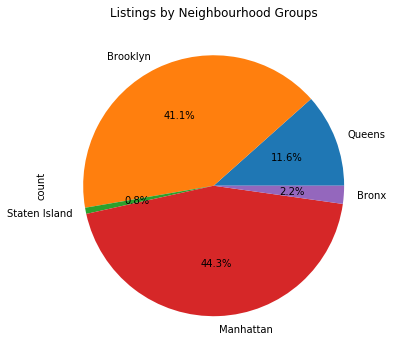

In [0]:
import pandas as pd
neighbourhood_group_data_pd = neighbourhood_group_data.toPandas()
neighbourhood_group_data_pd.index = neighbourhood_group_data_pd['neighbourhood_group']
plt = neighbourhood_group_data_pd.plot.pie(y='count', autopct='%1.1f%%', legend = False, title='Listings by Neighbourhood Groups', figsize=(16,6))


**18. Distinct neighbourhood count**

In [0]:
airbnb_schema.select("neighbourhood").distinct().count()

221

**19. Distinct neighbourhood**

In [0]:
airbnb_schema.groupby("neighbourhood").count().show()

+------------------+-----+
|     neighbourhood|count|
+------------------+-----+
|            Corona|   64|
|      Richmondtown|    1|
|      Prince's Bay|    4|
|       Westerleigh|    2|
|        Mill Basin|    4|
|      Civic Center|   52|
|        Douglaston|    8|
|        Mount Hope|   20|
|       Marble Hill|   12|
|         Rego Park|  106|
|     Dyker Heights|   12|
| Kew Gardens Hills|   26|
|      Dongan Hills|    7|
|Financial District|  744|
|       Bay Terrace|    6|
|           Midtown| 1545|
|   Jackson Heights|  186|
|           Bayside|   39|
|    Hell's Kitchen| 1958|
|        Highbridge|   27|
+------------------+-----+
only showing top 20 rows



In [0]:
from pyspark.sql import functions
from pyspark.sql.functions import col, avg
airbnb_schema.groupby("neighbourhood").count().sort(col("count").desc()).show(5)

+------------------+-----+
|     neighbourhood|count|
+------------------+-----+
|      Williamsburg| 3920|
|Bedford-Stuyvesant| 3714|
|            Harlem| 2658|
|          Bushwick| 2465|
|   Upper West Side| 1971|
+------------------+-----+
only showing top 5 rows



**21. Analysis of availability of apartments.**

In [0]:
avail_df = airbnb_schema.groupby("availability_365").count().sort(col("availability_365").asc())
avail_df.show()

+----------------+-----+
|availability_365|count|
+----------------+-----+
|               0|17533|
|               1|  408|
|               2|  270|
|               3|  306|
|               4|  233|
|               5|  340|
|               6|  245|
|               7|  219|
|               8|  233|
|               9|  193|
|              10|  165|
|              11|  173|
|              12|  172|
|              13|  162|
|              14|  173|
|              15|  159|
|              16|  151|
|              17|  130|
|              18|  125|
|              19|  135|
+----------------+-----+
only showing top 20 rows



**22. Distinct host id**

In [0]:
airbnb_schema.select("host_id").distinct().count()

37457

**23. Number of apartments under different room type**

In [0]:
# Number of apartments under different room type
room_type_data = airbnb_schema.where(airbnb_schema.room_type.isin("Private room","Entire home/apt","Shared room")).groupBy(airbnb_schema["room_type"]).count().sort(col("room_type").desc())
room_type_data.show()

+---------------+-----+
|      room_type|count|
+---------------+-----+
|    Shared room| 1160|
|   Private room|22326|
|Entire home/apt|25409|
+---------------+-----+



**24. Showing a general preference based on the room types. As we can see, most people prefer an Entire home/apt followed by Private Room and very few Shared rooms**

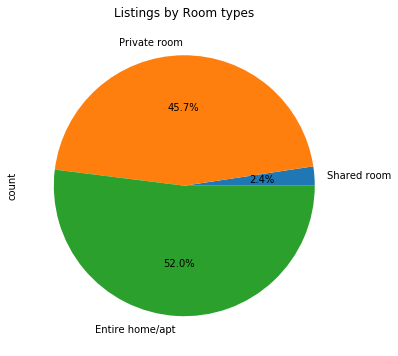

In [0]:
import pandas as pd
room_type_data_pd = room_type_data.toPandas()
room_type_data_pd.index = room_type_data_pd['room_type']
plt = room_type_data_pd.plot.pie(y='count', autopct='%1.1f%%', legend = False, title='Listings by Room types', figsize=(16,6))

**25. Combining room_type with neighbourhoodt**

In [0]:
neigh_room_type_schema = airbnb_schema.select(airbnb_schema["neighbourhood"], airbnb_schema["room_type"]).show()

+------------------+---------------+
|     neighbourhood|      room_type|
+------------------+---------------+
|        Kensington|   Private room|
|           Midtown|Entire home/apt|
|            Harlem|   Private room|
|      Clinton Hill|Entire home/apt|
|       East Harlem|Entire home/apt|
|       Murray Hill|Entire home/apt|
|Bedford-Stuyvesant|   Private room|
|    Hell's Kitchen|   Private room|
|   Upper West Side|   Private room|
|         Chinatown|Entire home/apt|
|   Upper West Side|Entire home/apt|
|    Hell's Kitchen|   Private room|
|       South Slope|   Private room|
|   Upper West Side|   Private room|
|      West Village|Entire home/apt|
|      Williamsburg|Entire home/apt|
|       Fort Greene|Entire home/apt|
|           Chelsea|   Private room|
|     Crown Heights|Entire home/apt|
|       East Harlem|Entire home/apt|
+------------------+---------------+
only showing top 20 rows



**26. Below table shows room type by neighbourhood group**

In [0]:
# room type by neighbourhood group.
neighbourhoodgrp_roomtype = airbnb_schema.select(airbnb_schema["neighbourhood_group"], airbnb_schema["room_type"]).groupBy("neighbourhood_group", "room_type").count()
neighbourhoodgrp_roomtype.show()

+-------------------+---------------+-----+
|neighbourhood_group|      room_type|count|
+-------------------+---------------+-----+
|      Staten Island|   Private room|  188|
|           Brooklyn|   Private room|10132|
|              Bronx|Entire home/apt|  379|
|             Queens|    Shared room|  198|
|      Staten Island|    Shared room|    9|
|          Manhattan|Entire home/apt|13199|
|          Manhattan|   Private room| 7982|
|          Manhattan|    Shared room|  480|
|              Bronx|    Shared room|   60|
|             Queens|   Private room| 3372|
|             Queens|Entire home/apt| 2096|
|              Bronx|   Private room|  652|
|      Staten Island|Entire home/apt|  176|
|           Brooklyn|Entire home/apt| 9559|
|           Brooklyn|    Shared room|  413|
+-------------------+---------------+-----+



**27. Showing the distribution of room types based on the neighbourhood group. From this we can get an idea of what room type are most popular in respective neighbourhood group. This is very important data for someone who would like to setup a new listing or update an existing one.**

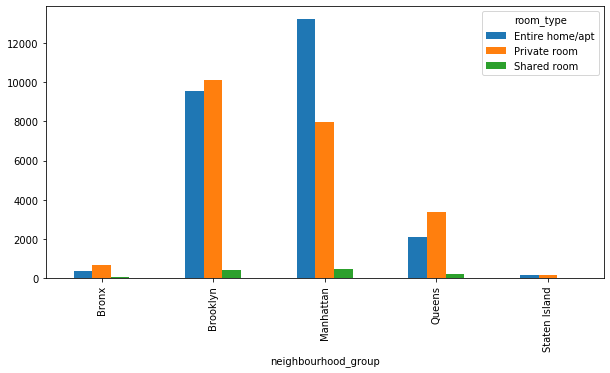

In [0]:
import pandas as pd
neighbourhoodgrp_roomtype_pd = neighbourhoodgrp_roomtype.toPandas()
pd.pivot_table(neighbourhoodgrp_roomtype_pd, index='neighbourhood_group', columns='room_type', values='count').plot.bar(figsize=(10,5))


**28. Combining neighbourhood with neighbourhood group**

In [0]:
nei_group_nei_schema = airbnb_schema.select(airbnb_schema["neighbourhood_group"], airbnb_schema["neighbourhood"])
nei_group_nei_schema.sort(col("neighbourhood_group").desc()).show()

+-------------------+---------------+
|neighbourhood_group|  neighbourhood|
+-------------------+---------------+
|      Staten Island|   Emerson Hill|
|      Staten Island|        Woodrow|
|      Staten Island|    Shore Acres|
|      Staten Island|  Tompkinsville|
|      Staten Island|       Arrochar|
|      Staten Island|  Tompkinsville|
|      Staten Island|       Arrochar|
|      Staten Island|  Tompkinsville|
|      Staten Island|Mariners Harbor|
|      Staten Island|     St. George|
|      Staten Island|        Concord|
|      Staten Island|  Tompkinsville|
|      Staten Island|        Concord|
|      Staten Island|        Clifton|
|      Staten Island|       Arrochar|
|      Staten Island|      Stapleton|
|      Staten Island|  Tompkinsville|
|      Staten Island|    Tottenville|
|      Staten Island|  Port Richmond|
|      Staten Island|  Tompkinsville|
+-------------------+---------------+
only showing top 20 rows



**29. Find the popular neighbourhood groups:**

Popular neighbourhood_groups are Manhattan, Brooklyn, Queens, Bronx

In [0]:

nei_group_nei_schema.groupBy("neighbourhood_group").count().sort(col("count").desc()).show()


+-------------------+-----+
|neighbourhood_group|count|
+-------------------+-----+
|          Manhattan|21661|
|           Brooklyn|20104|
|             Queens| 5666|
|              Bronx| 1091|
|      Staten Island|  373|
+-------------------+-----+



Above we check which neighbourhood group is the most popular based on the number of listings in that group. Also, how the count varies for other neighbourhood groups. **The result shows that Manhattan is the most popular neighbourhood group for people**. This would make sense as Manhattan is one the busiest areas in NYC and there are lot of things in and around Manhattan where people would be interested in going and they would prefer a listing close to the area for convinience

**30. Number of neighbourhood in popular neighbourhood_groups**


In [0]:
manhattan_nei = nei_group_nei_schema.where(nei_group_nei_schema.neighbourhood_group.like("Manhattan")).groupBy("neighbourhood").count().sort(col("count").desc())
brooklyn_nei =  nei_group_nei_schema.where(nei_group_nei_schema.neighbourhood_group.like("Brooklyn")).groupBy("neighbourhood").count().sort(col("count").desc())
queens_nei =  nei_group_nei_schema.where(nei_group_nei_schema.neighbourhood_group.like("Queens")).groupBy("neighbourhood").count().sort(col("count").desc())
bronx_nei =  nei_group_nei_schema.where(nei_group_nei_schema.neighbourhood_group.like("Bronx")).groupBy("neighbourhood").count().sort(col("count").desc())


**31. Combining neighbourhood_group, neighbourhood and room_type**

In [0]:
neigh_group_neigh_room_type_schema = airbnb_schema.select("neighbourhood_group", "neighbourhood", "room_type")

**32. Distribution of rooms in various neighbourhood in  Manhatten.**

In [0]:
print("Showing distribution for room_type = 'Private room' in Manhattan")
manhattan_nei_private = neigh_group_neigh_room_type_schema.where((col("neighbourhood_group")=="Manhattan") & (col("room_type")=="Private room")).groupBy("neighbourhood").count().sort(col("count").desc()).show()
print("Showing distribution for room_type = 'Shared room' in Manhattan")
manhattan_nei_shared = neigh_group_neigh_room_type_schema.where((col("neighbourhood_group").like("Manhatt%")) & (col("room_type")=="Shared room")).groupBy("neighbourhood").count().sort(col("count").desc()).show()
print("Showing distribution for room_type = 'Entire home/apt' in Manhattan")
manhattan_nei_entire_home = neigh_group_neigh_room_type_schema.where((col("neighbourhood_group")=="Manhattan") & (col("room_type")=="Entire home/apt")).groupBy("neighbourhood").count().sort(col("count").desc()).show()


Showing distribution for room_type = 'Private room' in Manhattan
+-------------------+-----+
|      neighbourhood|count|
+-------------------+-----+
|             Harlem| 1573|
|    Upper West Side|  675|
|     Hell's Kitchen|  672|
|       East Village|  660|
|        East Harlem|  586|
| Washington Heights|  576|
|    Upper East Side|  441|
|            Midtown|  422|
|    Lower East Side|  367|
|            Chelsea|  278|
|Morningside Heights|  192|
| Financial District|  162|
|          Chinatown|  156|
|             Inwood|  145|
|   Theater District|  122|
|               SoHo|  115|
|       West Village|  112|
|           Kips Bay|  112|
|  Greenwich Village|   99|
|           Gramercy|   89|
+-------------------+-----+
only showing top 20 rows

Showing distribution for room_type = 'Shared room' in Manhattan
+-------------------+-----+
|      neighbourhood|count|
+-------------------+-----+
|     Hell's Kitchen|   99|
|             Harlem|   49|
|    Upper East Side|   47|
|    

**33. Distribution of rooms in various neighbourhood in Brooklyn.**

In [0]:

print("Showing distribution for room_type = 'Private room' in Brooklyn")
brooklyn_nei_private = neigh_group_neigh_room_type_schema.where((col("neighbourhood_group")=="Brooklyn") & (col("room_type")=="Private room")).groupBy("neighbourhood").count().sort(col("count").desc()).show()
print("Showing distribution for room_type = 'Shared room' in Brooklyn")
brooklyn_nei_shared = neigh_group_neigh_room_type_schema.where((col("neighbourhood_group").like("Brooklyn")) & (col("room_type")=="Shared room")).groupBy("neighbourhood").count().sort(col("count").desc()).show()
print("Showing distribution for room_type = 'Entire home/apt' in Brooklyn")
brooklyn_nei_entire_home = neigh_group_neigh_room_type_schema.where((col("neighbourhood_group")=="Brooklyn") & (col("room_type")=="Entire home/apt")).groupBy("neighbourhood").count().sort(col("count").desc()).show()


Showing distribution for room_type = 'Private room' in Brooklyn
+--------------------+-----+
|       neighbourhood|count|
+--------------------+-----+
|  Bedford-Stuyvesant| 2038|
|        Williamsburg| 1997|
|            Bushwick| 1719|
|       Crown Heights|  780|
|          Greenpoint|  476|
|            Flatbush|  339|
|       East Flatbush|  289|
|Prospect-Lefferts...|  242|
|        Clinton Hill|  217|
|         Sunset Park|  205|
|         Fort Greene|  174|
|    Prospect Heights|  143|
|          Park Slope|  139|
|       East New York|  120|
|             Gowanus|  110|
|          Kensington|   98|
|        Borough Park|   94|
|         South Slope|   93|
|      Sheepshead Bay|   86|
|       Cypress Hills|   75|
+--------------------+-----+
only showing top 20 rows

Showing distribution for room_type = 'Shared room' in Brooklyn
+--------------------+-----+
|       neighbourhood|count|
+--------------------+-----+
|  Bedford-Stuyvesant|   85|
|            Bushwick|   68|
|     

**34. Distribution of rooms in various neighbourhood in Queens.**

In [0]:
# 
print("Showing distribution for room_type = 'Private room' in Queens")
queens_nei_private = neigh_group_neigh_room_type_schema.where((col("neighbourhood_group")=="Queens") & (col("room_type")=="Private room")).groupBy("neighbourhood").count().sort(col("count").desc()).show()
print("Showing distribution for room_type = 'Shared room' in Queens")
queens_nei_shared = neigh_group_neigh_room_type_schema.where((col("neighbourhood_group")=="Queens") & (col("room_type")=="Shared room")).groupBy("neighbourhood").count().sort(col("count").desc()).show()
print("Showing distribution for room_type = 'Entire home/apt' in Queens")
queens_nei_entire_home = neigh_group_neigh_room_type_schema.where((col("neighbourhood_group")=="Queens") & (col("room_type")=="Entire home/apt")).groupBy("neighbourhood").count().sort(col("count").desc()).show()


Showing distribution for room_type = 'Private room' in Queens
+-------------------+-----+
|      neighbourhood|count|
+-------------------+-----+
|            Astoria|  494|
|           Flushing|  307|
|          Ridgewood|  284|
|   Long Island City|  283|
|          Sunnyside|  203|
|   Ditmars Steinway|  186|
|           Woodside|  171|
|           Elmhurst|  171|
|            Jamaica|  145|
|      East Elmhurst|  126|
|    Jackson Heights|  114|
|       Forest Hills|   75|
|          Woodhaven|   66|
|            Maspeth|   63|
|          Rego Park|   59|
|      Richmond Hill|   57|
|Springfield Gardens|   51|
|         St. Albans|   49|
|           Rosedale|   43|
|          Briarwood|   35|
+-------------------+-----+
only showing top 20 rows

Showing distribution for room_type = 'Shared room' in Queens
+----------------+-----+
|   neighbourhood|count|
+----------------+-----+
|       Sunnyside|   25|
|         Astoria|   25|
|          Corona|   24|
| Jackson Heights|   14|
|Lon

**35. Distribution of rooms in various neighbourhood in Bronx.**

In [0]:
 print("Showing distribution for room_type = 'Private room' in Bronx")
bronx_nei_private = neigh_group_neigh_room_type_schema.where((col("neighbourhood_group")=="Bronx") & (col("room_type")=="Private room")).groupBy("neighbourhood").count().sort(col("count").desc()).show()
print("Showing distribution for room_type = 'Shared room' in Bronx")
bronx_nei_shared = neigh_group_neigh_room_type_schema.where((col("neighbourhood_group")=="Bronx") & (col("room_type")=="Shared room")).groupBy("neighbourhood").count().sort(col("count").desc()).show()
print("Showing distribution for room_type = 'Entire home/apt' in Bronx")
bronx_nei_entire_home = neigh_group_neigh_room_type_schema.where((col("neighbourhood_group")=="Bronx") & (col("room_type")=="Entire home/apt")).groupBy("neighbourhood").count().sort(col("count").desc()).show()


Showing distribution for room_type = 'Private room' in Bronx
+------------------+-----+
|     neighbourhood|count|
+------------------+-----+
|       Kingsbridge|   49|
|           Fordham|   46|
|          Longwood|   41|
|        Mott Haven|   33|
|         Wakefield|   31|
|         Concourse|   30|
|          Allerton|   26|
|       Parkchester|   24|
|           Norwood|   24|
|    Williamsbridge|   21|
| Concourse Village|   21|
|        Highbridge|   20|
| Claremont Village|   20|
|           Belmont|   19|
|       Hunts Point|   17|
|University Heights|   15|
|       Port Morris|   14|
|       Throgs Neck|   13|
|    Morris Heights|   12|
|      Clason Point|   11|
+------------------+-----+
only showing top 20 rows

Showing distribution for room_type = 'Shared room' in Bronx
+-----------------+-----+
|    neighbourhood|count|
+-----------------+-----+
|      Port Morris|   16|
|      Parkchester|    6|
|          Fordham|    4|
|      Kingsbridge|    3|
|       Morrisania|    

**36. Total average price of various room types**

In [0]:
nei_group_nei_room_price_schema = airbnb_schema.select("neighbourhood_group", "neighbourhood", "room_type", "price")
nei_group_nei_room_price_schema.agg(avg(col("price")).alias("Total average price")).show()
# Total average price of private room.
nei_group_nei_room_price_schema.where(col("room_type")=="Private room").agg(avg(col("price")).alias("Total average price of private room")).show()
# Total average price of shared room.
nei_group_nei_room_price_schema.where(col("room_type")=="Shared room").agg(avg(col("price")).alias("Total average price of shared room")).show()
# Total average price of entire home/apt.
nei_group_nei_room_price_schema.where(col("room_type")=="Entire home/apt").agg(avg(col("price")).alias("Total average price of entire home room")).show()

+-------------------+
|Total average price|
+-------------------+
|  152.7206871868289|
+-------------------+

+-----------------------------------+
|Total average price of private room|
+-----------------------------------+
|                  89.78097285675894|
+-----------------------------------+

+----------------------------------+
|Total average price of shared room|
+----------------------------------+
|                 70.12758620689655|
+----------------------------------+

+---------------------------------------+
|Total average price of entire home room|
+---------------------------------------+
|                     211.79424613325986|
+---------------------------------------+



**37. Average price of various room types in Manhatton**

In [0]:
manhattan_nei_private = nei_group_nei_room_price_schema.where((col("neighbourhood_group")=="Manhattan") & (col("room_type")=="Private room")).agg(avg(col("price")).alias("Average price of private room in Manhattan")).show()
manhattan_nei_shared = nei_group_nei_room_price_schema.where((col("neighbourhood_group")=="Manhattan") & (col("room_type")=="Shared room")).agg(avg(col("price")).alias("Average price of shared room in Manhattan")).show()
manhattan_nei_entire_home = nei_group_nei_room_price_schema.where((col("neighbourhood_group")=="Manhattan") & (col("room_type")=="Entire home/apt")).agg(avg(col("price")).alias("Average price of entire home/apt in Manhattan")).show()


+------------------------------------------+
|Average price of private room in Manhattan|
+------------------------------------------+
|                         116.7766224004009|
+------------------------------------------+

+-----------------------------------------+
|Average price of shared room in Manhattan|
+-----------------------------------------+
|                        88.97708333333334|
+-----------------------------------------+

+---------------------------------------------+
|Average price of entire home/apt in Manhattan|
+---------------------------------------------+
|                           249.23910902341086|
+---------------------------------------------+



**38. Average price of various room types in Brooklyn**

In [0]:
brooklyn_nei_private = nei_group_nei_room_price_schema.where((col("neighbourhood_group")=="Brooklyn") & (col("room_type")=="Private room")).agg(avg(col("price")).alias("Average price of private room in Brooklyn")).show()
brooklyn_nei_shared = nei_group_nei_room_price_schema.where((col("neighbourhood_group")=="Brooklyn") & (col("room_type")=="Shared room")).agg(avg(col("price")).alias("Average price of shared room in Brooklyn")).show()
brooklyn_nei_entire_home = nei_group_nei_room_price_schema.where((col("neighbourhood_group")=="Brooklyn") & (col("room_type")=="Entire home/apt")).agg(avg(col("price")).alias("Average price of entire home/apt in Brooklyn")).show()


+-----------------------------------------+
|Average price of private room in Brooklyn|
+-----------------------------------------+
|                          76.500098697197|
+-----------------------------------------+

+----------------------------------------+
|Average price of shared room in Brooklyn|
+----------------------------------------+
|                       50.52784503631961|
+----------------------------------------+

+--------------------------------------------+
|Average price of entire home/apt in Brooklyn|
+--------------------------------------------+
|                          178.32754472225128|
+--------------------------------------------+



**39. Average price of various room types in Queens**

In [0]:
# Average price of various room types in various (popular) neighbourhood groups
# In Queens.
queens_nei_private = nei_group_nei_room_price_schema.where((col("neighbourhood_group")=="Queens") & (col("room_type")=="Private room")).agg(avg(col("price")).alias("Average price of private room in Queens")).show()
queens_nei_shared = nei_group_nei_room_price_schema.where((col("neighbourhood_group")=="Queens") & (col("room_type")=="Shared room")).agg(avg(col("price")).alias("Average price of shared room in Queens")).show()
queens_nei_entire_home = nei_group_nei_room_price_schema.where((col("neighbourhood_group")=="Queens") & (col("room_type")=="Entire home/apt")).agg(avg(col("price")).alias("Average price of entire home/apt in Queens")).show()


+---------------------------------------+
|Average price of private room in Queens|
+---------------------------------------+
|                      71.76245551601423|
+---------------------------------------+

+--------------------------------------+
|Average price of shared room in Queens|
+--------------------------------------+
|                     69.02020202020202|
+--------------------------------------+

+------------------------------------------+
|Average price of entire home/apt in Queens|
+------------------------------------------+
|                        147.05057251908397|
+------------------------------------------+



**40. Average price of various room types in Bronx**

In [0]:
 # Average price of various room types in various (popular) neighbourhood groups
# In Bronx.
bronx_nei_private = nei_group_nei_room_price_schema.where((col("neighbourhood_group")=="Bronx") & (col("room_type")=="Private room")).agg(avg(col("price")).alias("Average price of private room in Bronx")).show()
bronx_nei_shared = nei_group_nei_room_price_schema.where((col("neighbourhood_group")=="Bronx") & (col("room_type")=="Shared room")).agg(avg(col("price")).alias("Average price of shared room in Bronx")).show()
bronx_nei_entire_home = nei_group_nei_room_price_schema.where((col("neighbourhood_group")=="Bronx") & (col("room_type")=="Entire home/apt")).agg(avg(col("price")).alias("Average price of entire home/apt in Bronx")).show()


+--------------------------------------+
|Average price of private room in Bronx|
+--------------------------------------+
|                     66.78834355828221|
+--------------------------------------+

+-------------------------------------+
|Average price of shared room in Bronx|
+-------------------------------------+
|                                 59.8|
+-------------------------------------+

+-----------------------------------------+
|Average price of entire home/apt in Bronx|
+-----------------------------------------+
|                        127.5065963060686|
+-----------------------------------------+



**41. Total frequency of nights people stay in all the neighbourhood groups**

In [0]:

nei_group_nei_min_nights_schema = airbnb_schema.select("neighbourhood_group", "neighbourhood", "minimum_nights")
nei_group_nei_min_nights_schema.na.drop(subset=["minimum_nights"]).groupBy("minimum_nights").count().sort(col("minimum_nights").asc()).show()

+--------------+-----+
|minimum_nights|count|
+--------------+-----+
|             1|12720|
|             2|11696|
|             3| 7999|
|             4| 3303|
|             5| 3034|
|             6|  752|
|             7| 2058|
|             8|  130|
|             9|   80|
|            10|  483|
|            11|   33|
|            12|   91|
|            13|   54|
|            14|  562|
|            15|  279|
|            16|   18|
|            17|   14|
|            18|   28|
|            19|    8|
|            20|  223|
+--------------+-----+
only showing top 20 rows



**42. Total frequency of nights people stay in various (popular) neighbourhood groups**

In [0]:
# Total frequency of nights people stay in various (popular) neighbourhood groups
total_manhatten  = nei_group_nei_min_nights_schema.where((col("neighbourhood_group")=="Manhattan")).count()
print(total_manhatten)
# In Manhattan.
manhattan_nei = nei_group_nei_min_nights_schema.where(col("neighbourhood_group")=="Manhattan").groupBy("minimum_nights").count().sort(col("minimum_nights").asc()).show()
# In Brooklyn
brooklyn_nei = nei_group_nei_min_nights_schema.where((col("neighbourhood_group")=="Brooklyn")).groupBy("minimum_nights").count().sort(col("minimum_nights").asc()).show()
# In Queens
queens_nei = nei_group_nei_min_nights_schema.where((col("neighbourhood_group")=="Queens")).groupBy("minimum_nights").count().sort(col("minimum_nights").asc()).show()
# In Bronx
bronx_nei = nei_group_nei_min_nights_schema.where((col("neighbourhood_group")=="Bronx")).groupBy("minimum_nights").count().sort(col("minimum_nights").asc()).show()


21661
+--------------+-----+
|minimum_nights|count|
+--------------+-----+
|             1| 5418|
|             2| 4506|
|             3| 3463|
|             4| 1508|
|             5| 1337|
|             6|  362|
|             7|  889|
|             8|   63|
|             9|   33|
|            10|  203|
|            11|   17|
|            12|   51|
|            13|   20|
|            14|  248|
|            15|  107|
|            16|    9|
|            17|    6|
|            18|    8|
|            19|    6|
|            20|   89|
+--------------+-----+
only showing top 20 rows

+--------------+-----+
|minimum_nights|count|
+--------------+-----+
|             1| 4650|
|             2| 5321|
|             3| 3597|
|             4| 1434|
|             5| 1383|
|             6|  318|
|             7|  927|
|             8|   63|
|             9|   38|
|            10|  241|
|            11|   14|
|            12|   38|
|            13|   29|
|            14|  255|
|            15|  135|
| 



**43. Let us check the 'number_of_reviews' column. We can find out the most popular listings based on the number of reviews.**

**Here we display top 20 records**

In [0]:
# 'number_of_reviews' column
from operator import attrgetter
data = airbnb_schema.rdd.top(20, attrgetter("number_of_reviews"))
most_reviewed_df = spark.sparkContext.parallelize(data).toDF()
most_reviewed_df.show()
most_reviewed_df.first()
most_reviewed_df.select("name", "neighbourhood_group", "neighbourhood", "room_type", "number_of_reviews").show()

+--------------------+--------+-------------------+---------------+--------+---------+---------------+-----+--------------+-----------------+-----------------+------------------------------+----------------+
|                name| host_id|neighbourhood_group|  neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|reviews_per_month|calculated_host_listings_count|availability_365|
+--------------------+--------+-------------------+---------------+--------+---------+---------------+-----+--------------+-----------------+-----------------+------------------------------+----------------+
|Room near JFK Que...|47621202|             Queens|        Jamaica| 40.6673|-73.76831|   Private room|   47|             1|              629|            14.58|                             2|             333|
|Great Bedroom in ...| 4734398|          Manhattan|         Harlem|40.82085|-73.94025|   Private room|   49|             1|              607|             7.75|         

**As we can see, the host with name = 'Room near JFK Queen Bed' and host_id = '47621202' has the most reviews (629 reviews)**

**44. The average price for the listing for the 20 most reviewed listings is $91. We can also observe that 15/20 listings are Private rooms, 4/20 are Entire home/apt and only 1 in the top 20 is a Shared room.**

In [0]:
most_reviewed_df.agg(avg("price")).show()

+----------+
|avg(price)|
+----------+
|     91.45|
+----------+



**45. We will now look at the latitude and longitude columns in the dataset. We can take a look at how the listings are distributed across geography. This will also tell us that which geographic region shows promise for starting a new listing.**

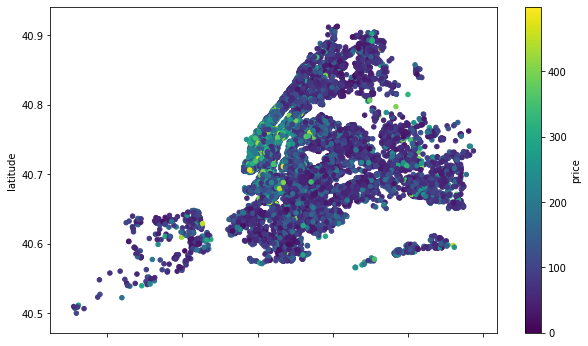

In [0]:
import pandas as pd
import matplotlib.pyplot as matp
airbnb_schema_pd = airbnb_schema.toPandas()
airbnb_schema_pd_trimmed = airbnb_schema_pd[airbnb_schema_pd['price'] < 500]
airbnb_schema_pd_trimmed.plot.scatter(x='longitude', y='latitude', c='price', cmap=matp.get_cmap('viridis'), figsize=(10,6))